# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import pandas as pd
from pandas import json_normalize

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

from bs4 import BeautifulSoup
import unicodedata

import logging
import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import scipy.spatial.distance

import umap

TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
# ----------- NLP modules ----------- #

from gensim.corpora import Dictionary
from gensim.models import Phrases, hdpmodel, LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as pgensim
pyLDAvis.enable_notebook()

# Topic modelling with LDA
---

As a first approach I will **train an LDA topic model**, roughly following [this gensim tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py). [This article](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#19findthemostrepresentativedocumentforeachtopic) proved to be a good resource for me too.

- The Latent Dirichlet Allocation (LDA) is is a way of **automatically discovering topics that documents in the corpus contain**. 
- The algorithm attempts to **describe each document as a mix of these topics.**
- The number of topics is a hyperparameter that has to be specified by the user. 
- **LDA is unsupervised**. The topics themselves are not specified up front but rather revealed during the training process. 
- **The topics are not necessarily aligned with how a human may naturally categorize documents.** 
- **The topic composition has to be interpreted by the user** and needs domain knowledge.

# Load and prepare data

In [3]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")

In [4]:
# Remove all podcast that weren't updated after 2018.
df.releaseDate = pd.to_datetime(df.releaseDate)
to_drop = df[df.releaseDate.dt.year<2019].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(6636, 29)

I load the prepared tokens and concatenate these to one single text string per podcast sample. Since LDA is based on a bag-of-word model, I provide a function that allows to balance the text volume between podcast and episode descriptions. 

In [5]:
pod_tokens = pd.read_parquet("_data/clean_pod_token.parq")
eps_tokens = pd.read_parquet("_data/clean_eps_token.parq")

pod_tokens = [x[0] for x in pod_tokens.values]
eps_tokens = [x[0] for x in eps_tokens.values]

In [6]:
# Set a factor to balance the text volume between podcast description and episode description.
# A value of 1 means, podcast texts are repeated until they are roughly as long as the episode texts.
balance = 0.1

all_tokens = []

for pods, eps in zip(pod_tokens, eps_tokens):
    ratio = len(eps)/len(pods)
    ratio = int(ratio * balance)
    pods = np.tile(pods, reps=ratio)
    all_tokens.append(np.concatenate([pods, eps]))
    
del pod_tokens
del eps_tokens

In [7]:
# Filter out empty tokens and tokens that are less than n characters long.
min_len = 3
all_tokens = [[x for x in doc if len(x)>=min_len] for doc in all_tokens]

In [8]:
%%time
# Create a dictionary representation of the documents.
all_dict = Dictionary(all_tokens)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents.
# Setting the defaults from the gensim tutorial here.
all_dict.filter_extremes(no_below=20, no_above=0.5)

CPU times: user 11.8 s, sys: 113 ms, total: 11.9 s
Wall time: 11.9 s


In [9]:
top_n = 20
display(all_dict.most_common()[:top_n])

[('interview', 117690),
 ('buch', 103859),
 ('gerne', 94366),
 ('helfen', 79410),
 ('tipps', 77369),
 ('kind', 75745),
 ('mögen', 75482),
 ('gast', 73041),
 ('frau', 70837),
 ('business', 69225),
 ('erfolgreich', 68120),
 ('bit', 64020),
 ('unternehmen', 63108),
 ('erfolg', 62937),
 ('information', 59922),
 ('deutsch', 59015),
 ('bewertung', 58289),
 ('persönlich', 57859),
 ('unterstützen', 57383),
 ('heutig', 52740)]

Create a bag-of-word corpus.

In [10]:
all_corpus = [all_dict.doc2bow(doc) for doc in all_tokens]
print(f'Number of unique tokens: {len(all_dict)}')
print(f'Number of documents: {len(all_corpus)}')

Number of unique tokens: 47550
Number of documents: 6636


In [11]:
# Print words from first document.
print('token_id', 'freq', 'word', sep='\t')
for (token_id, freq) in all_corpus[0][:10]:
    print(token_id, '', freq, all_dict[token_id], sep='\t')

token_id	freq	word
0		2	advent
1		1	adventskalender
2		1	affiliate
3		1	analysieren
4		1	ankündigung
5		3	ansonsten
6		1	app
7		9	appeared
8		2	arbeit
9		1	arbeitsplatz


In [12]:
# Create an index to word dictionary.
all_id2word = all_dict.id2token

# Train the LDA model

In [16]:
%%time

NUM_TOPICS = 100

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# logging.disable()

model = LdaModel(
            num_topics  = NUM_TOPICS,
            chunksize   = 8000,
            passes      = 20,
            iterations  = 400,

            corpus      = all_corpus,
            id2word     = all_id2word,

            alpha       = 'auto',
            eta         = 'auto',
            eval_every  = None
    )

model.save(f"_models/lda_high_{NUM_TOPICS}_cleaned")

In [13]:
NUM_TOPICS = 100
model = LdaModel.load(f"_models/lda_high_{NUM_TOPICS}_cleaned")

In [17]:
# Calculate overall perplexity as a measure of how good the model is. Lower is better.
print(f'Model perplexity: {model.log_perplexity(all_corpus):.2f}')

# Compute the coherence score as an alternative quality metric for the LDA model.
# https://rare-technologies.com/what-is-topic-coherence/
coherence_model_lda = CoherenceModel(model=model, 
                                     texts=all_tokens, 
                                     dictionary=all_dict, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print(f'Model coherence score: {coherence_lda:.2f}')

# Analyze the topics

**Print out «Top topics»** – get the topics with the highest coherence score.

In [14]:
top_topics = model.top_topics(all_corpus)

In [15]:
# Calculate the average topic coherence.
# This is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print(f'Average topic coherence: {avg_topic_coherence:.2f}\n')

Average topic coherence: -1.54



In [17]:
print("The indices of the top_topics aren't equal to those from show_topics.\n")
# Pretty print topics and related terms.
for topic_idx, (topic_terms, _) in enumerate(top_topics):
    if topic_idx==10:
        break
    print(topic_idx, ":", end=' ')
    for _, term in topic_terms:
        print(term, sep=' ', end=' ')
    print()
print()

The indices of the top_topics aren't equal to those from show_topics.

0 : erfolg groups ziel bewertung gruppe bit mindset business erfolgreich arbeiten persönlich erreichen interview bewerten mögen schritt helfen life veränderung bekommen 
1 : meditation inner gedanke helfen freude gefühl angst tipps positiv persönlich fühlen alltag körper achtsamkeit glücklich gerne schritt mögen freuen bewusst 
2 : kind beziehung eltern familie mama frau mutter partner gerne mögen tipps angst vater gefühl schule helfen erfahrung reden alltag sex 
3 : arbeit idee arbeiten team unternehmen work kunde ding new problem projekt buch methode digital unternehmer ziel heutig design nutzen leute 
4 : dnx leute halt life berlin glauben bisschen sagen geld nomade cool mögen digital komm kostenlos machen business ding persönlich denken 
5 : business kostenlos erfolgreich onlinekurs kurs marketing schritt gruppe aufbauen katharina gratis tipps challenge webinar mögen kunde starten interview strategie nutzen 
6 :

**Print out all topics**

I now print the top 20 topics from the unranked topic list (of 100 topics in total).

In [19]:
lda_topics = model.show_topics(num_topics=100, num_words=20)
top_n = 20

for topic_idx, topic_terms in enumerate(lda_topics):
    if topic_idx==top_n:
        break
    print(topic_terms[0], ":", end=' ')
    for term in topic_terms[1].split(" + "):
        print(term.split("*")[1].replace("\"", ""), end=" ")
    print()
print()

0 : show gast live kreuzfahrt star fernsehen song rtl ausgabe musik staffel deutsch hit norbert album schiff diskutieren cruises spielen kreuzfahrten 
1 : auto essen elektromobilität kochen rezept energie koch elektroauto küche mobilität restaurant food energiewende zukunft fahren mobility model batterie update gast 
2 : aktie geld investieren etfs börse depot gold geldanlage handeln bewertung trading etf rendite investor net risiko anleger aufforderung kauf immobilie 
3 : startup wrestling omr gründer deutsch deutschrap wwe rap million insider ceo review investor euro startups interview djs aka capital unternehmen 
4 : buch geburt verlag lesen hörspiel roman autor autorin deutschlandfunk schwangerschaft schreiben erscheinen interview beitrag literatur seite audiodatei frau kind regie 
5 : laufen hsv fußball spiel running wünschen trainer spieltag marathon lauf fragen wagen lucky bundesliga fan achilles reden saison bild läufer 
6 : bit folge times krypto show analyse unterstützen rumb

## Get topic embeddings and labels for documents

In [16]:
# Get topic probabilities for all documents.
tmp = model.get_document_topics(all_corpus)

# # Alternatively:
# doc_lda = model[all_corpus]

# Transform to document vectors.
topic_vectors = pd.DataFrame([dict(x) for x in tmp])

# Sort columns.
topic_vectors = topic_vectors.T.sort_index().T

# Fill empty values with 0.
topic_vectors.fillna(0, inplace=True)

# Save topic vectors for later use
topic_vectors.columns = topic_vectors.columns.astype(str)
topic_vectors.to_parquet("_models/vectors_lda.parq")

# Get topic labels by retrieving the topic ID with the highest score.
topic_labels = topic_vectors.values.argmax(axis=1)

# # Get the probability for each word in each topic.
# model.get_topics().shape

df["topic_label"] = topic_labels

- By plotting the number of documents belonging to each topic we see that the distribution isn't balanced. 
- It rather has a few topics with very high document count and a long tail of topics with lower counts. 
- For clarity: I calculated just with the highest ranking topic for a document and not with the whole topic mix.

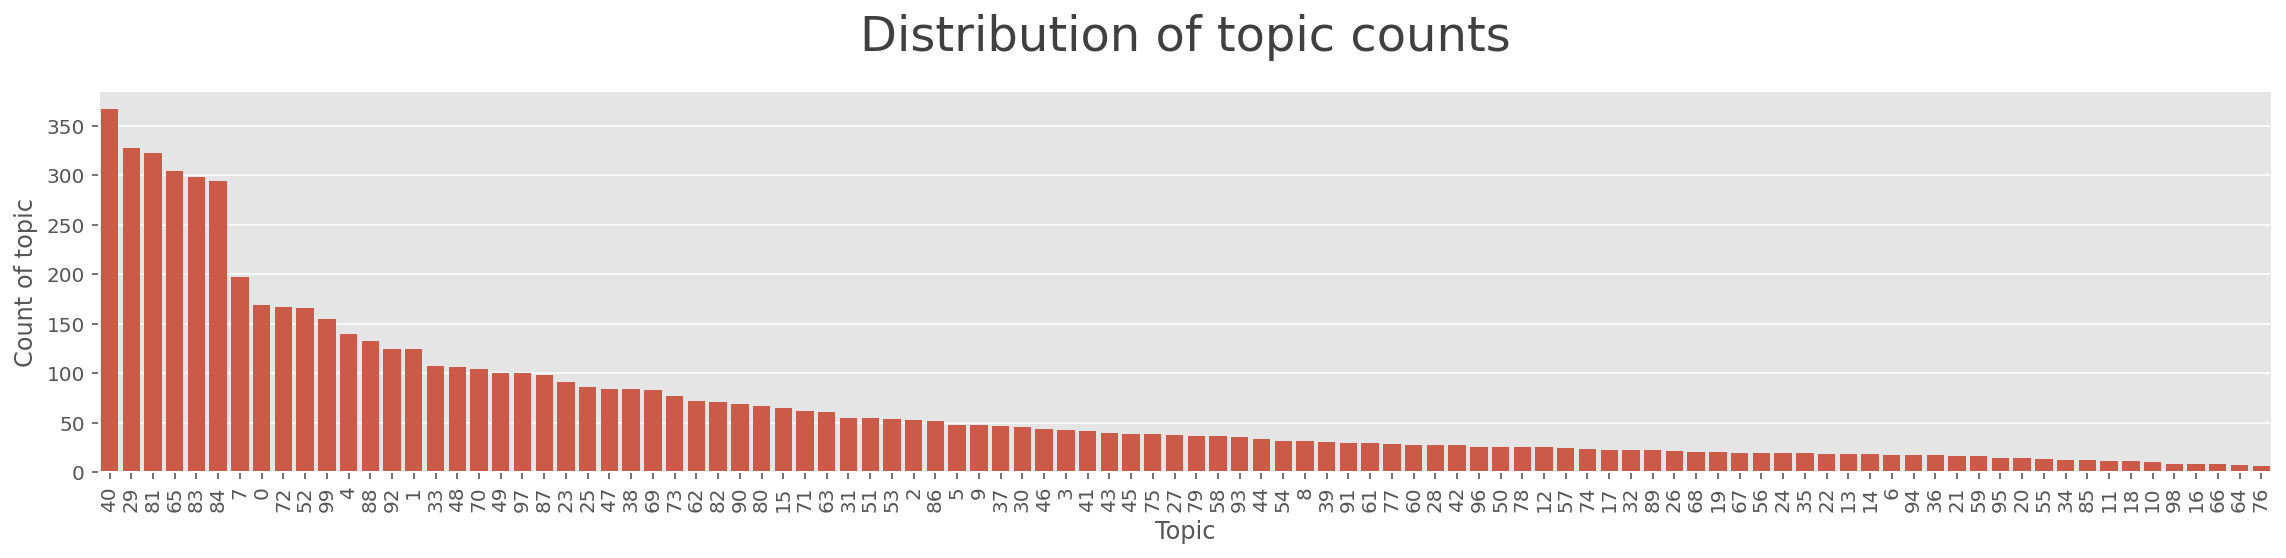

In [21]:
fig, ax = plt.subplots(figsize=(16, 4))
tmp = df.topic_label.value_counts().sort_values(ascending=False)
tmp = pd.DataFrame(tmp)
tmp.reset_index(inplace=True)
sns.barplot(data=tmp, y=tmp["topic_label"], x=tmp["index"], color=DEFAULT_COLORS[0], order=tmp["index"])
plt.title("Distribution of topic counts", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Topic")
plt.ylabel("Count of topic")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Now I try to get a sense, how podcasts in a particular genre are distributed over the various topics.
- As an example: Most podcasts that have `Nachrichten` as their primary genre in the metadata belong to topic #65.
- Printing the top terms for that topic reveals that this is a meaningful classification.

In [56]:
# Get value counts of topic labels to which a primary genre belongs. 
cols = ['artistName', 'title', 'subtitle', 'summary', 'primary_genre', 'topic_label']
topic_ = "Nachrichten"
print(f"Value counts of topic labels for primary genre «{topic_}».\n")
tmp = df[df.primary_genre==topic_][cols].topic_label.value_counts()[:10]
display(tmp)
print()
print(f"Topic terms for primary genre «{topic_}")
print([term[0] for term in model.show_topic(tmp.index[0], topn=50)])

Value counts of topic labels for primary genre «Nachrichten».



65    71
4     11
41     5
83     5
49     4
74     4
29     3
97     3
1      3
91     3
Name: topic_label, dtype: int64


Topic terms for primary genre «Nachrichten
['politik', 'moderation', 'spd', 'cdu', 'deutsch', 'redaktion', 'usa', 'partei', 'europa', 'nachricht', 'kritik', 'krise', 'präsident', 'wahl', 'politisch', 'zeitung', 'grüne', 'erreichen', 'gesellschaft', 'land', 'wirtschaft', 'produktion', 'bundestag', 'diskutieren', 'lage', 'regierung', 'interview', 'berlin', 'afghanistan', 'coronavirus', 'politiker', 'fdp', 'afd', 'berichten', 'bundestagswahl', 'union', 'bundesregierung', 'staat', 'maßnahme', 'china', 'folge', 'debatte', 'anregung', 'fordern', 'nrw', 'chef', 'stadt', 'korrespondent', 'mitarbeit', 'bedeuten']


## Examining the topic embeddings using PCA and UMAP

Now, let's explore the topic vectors by reducing their dimensionality with PCA and UMAP and scatter plot podcasts and topics.

### PCA

- The curve of explained variance of the PCA'ed vectors is not particularly steep. 
- I interpret this as an indication, that 100 as the number of learned topics (our hyperparameter for LDA) is sensible. The resulting vectors contain substantial information throughout their components and only can be compressed by PCA up to a certain degree.
- The first 2 components represent just ~11% of the information. Plotting the PCA'ed vectors will therefore only show this much information in the data.

The first 2 components of PCA'ed vectors capture 10.60% of the total variance of the data.



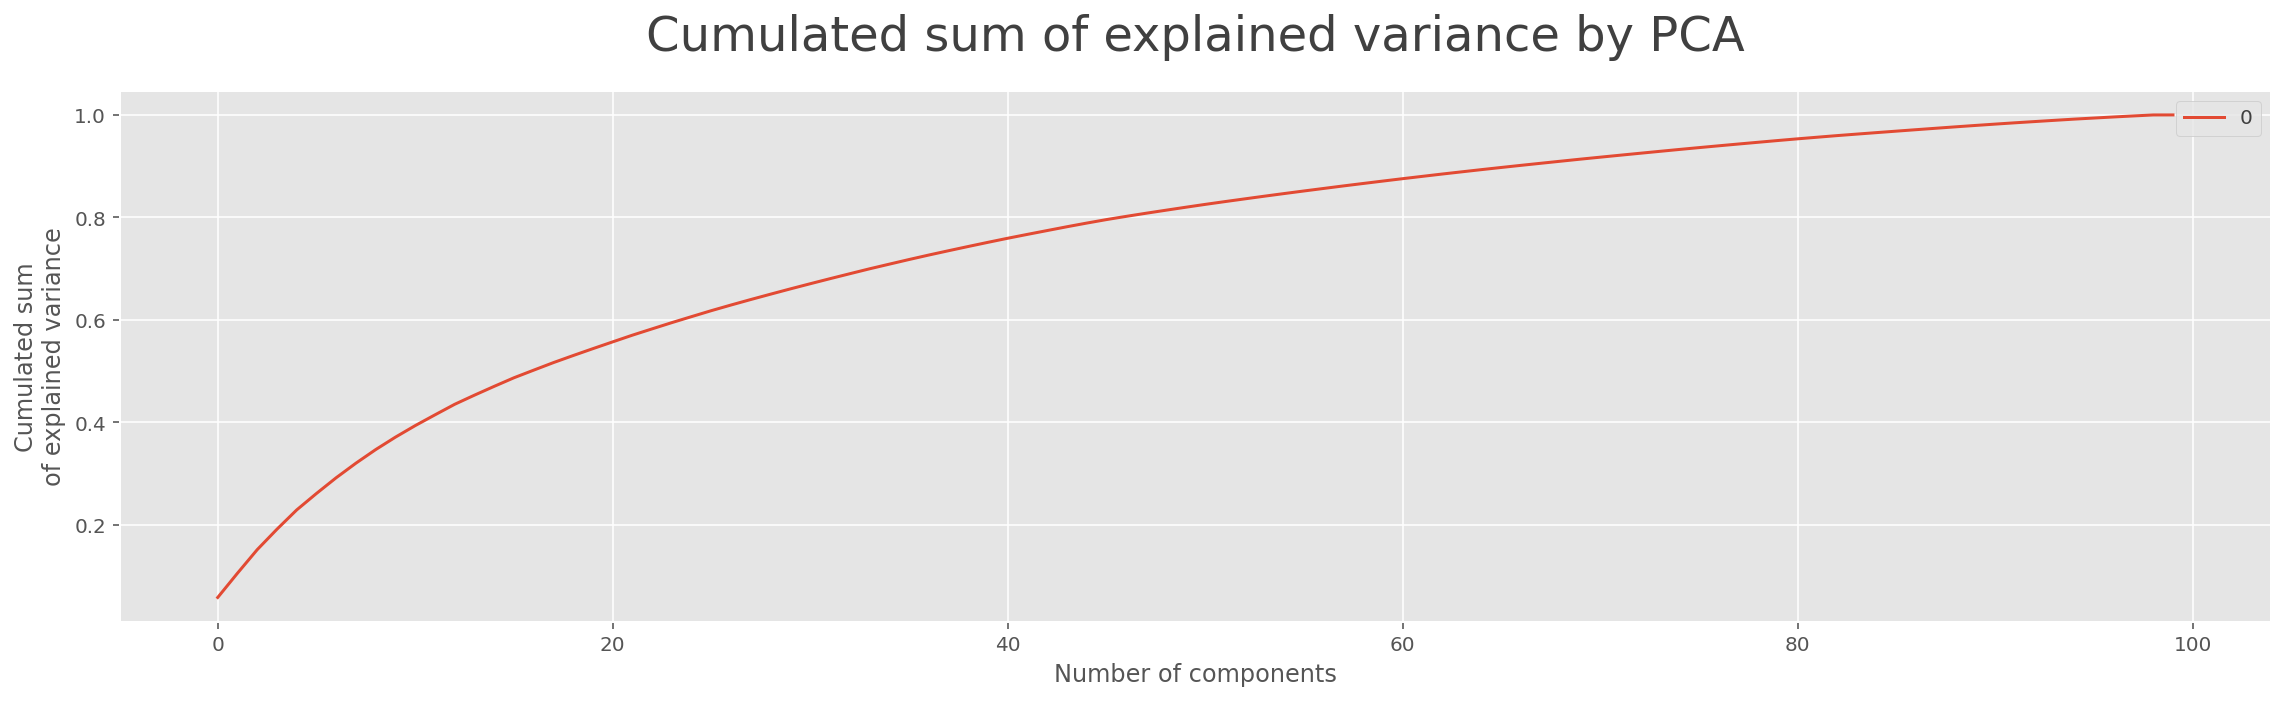

In [67]:
pca = PCA(random_state=0)
embed_pca = pca.fit_transform(topic_vectors)
explained_variance = pca.explained_variance_ratio_.cumsum()
print(f"The first 2 components of PCA'ed vectors capture {explained_variance[1]*100:.2f}% of the total variance of the data.\n")

fig, ax = plt.subplots(figsize=(16, 5))
pd.DataFrame(explained_variance).plot(ax=ax)
plt.title("Cumulated sum of explained variance by PCA", size=TITLE_SIZE, pad=TITLE_PAD)
plt.xlabel("Number of components")
plt.ylabel("Cumulated sum\nof explained variance")
plt.tight_layout()
plt.show()

In [68]:
def create_graph(embedding, topic_centers, title_text):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.scatterplot(data=embedding, x="x", y="y", hue="labels", palette="tab20", ax=ax, s=10)
    for idx, row in topic_centers.iterrows():
        ax.text(row.x, row.y, str(idx), 
                fontsize=12, 
                weight='bold',
               )

    ax.set_facecolor("white")
    plt.title(title_text, size=TITLE_SIZE, pad=TITLE_PAD)
    plt.legend([])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

- Topics #65, #40 and to a lesser degree #81 and #29 dominate the plot.
- This makes sense, since these topics are the four most common learned topics by LDA. To optimally express the variance in the data the PCA algorithm will naturally represent these topics in the first two components.

In [69]:
for topic_id in [65, 40, 81, 29]:
    print(f"Topic terms for topic id «#{topic_id}")
    print([term[0] for term in model.show_topic(topic_id, topn=20)])
    print()

Topic terms for topic id «#65
['politik', 'moderation', 'spd', 'cdu', 'deutsch', 'redaktion', 'usa', 'partei', 'europa', 'nachricht', 'kritik', 'krise', 'präsident', 'wahl', 'politisch', 'zeitung', 'grüne', 'erreichen', 'gesellschaft', 'land']

Topic terms for topic id «#40
['meditation', 'inner', 'gedanke', 'helfen', 'freude', 'gefühl', 'angst', 'tipps', 'positiv', 'persönlich', 'fühlen', 'alltag', 'körper', 'achtsamkeit', 'glücklich', 'gerne', 'schritt', 'mögen', 'freuen', 'bewusst']

Topic terms for topic id «#81
['kind', 'beziehung', 'eltern', 'familie', 'mama', 'frau', 'mutter', 'partner', 'gerne', 'mögen', 'tipps', 'angst', 'vater', 'gefühl', 'schule', 'helfen', 'erfahrung', 'reden', 'alltag', 'sex']

Topic terms for topic id «#29
['reden', 'kommentar', 'diesmal', 'leute', 'schön', 'paar', 'bisschen', 'fall', 'garten', 'sitzen', 'weiß', 'passieren', 'voll', 'sagen', 'halten', 'hörer', 'bitte', 'schreiben', 'andi', 'seite']



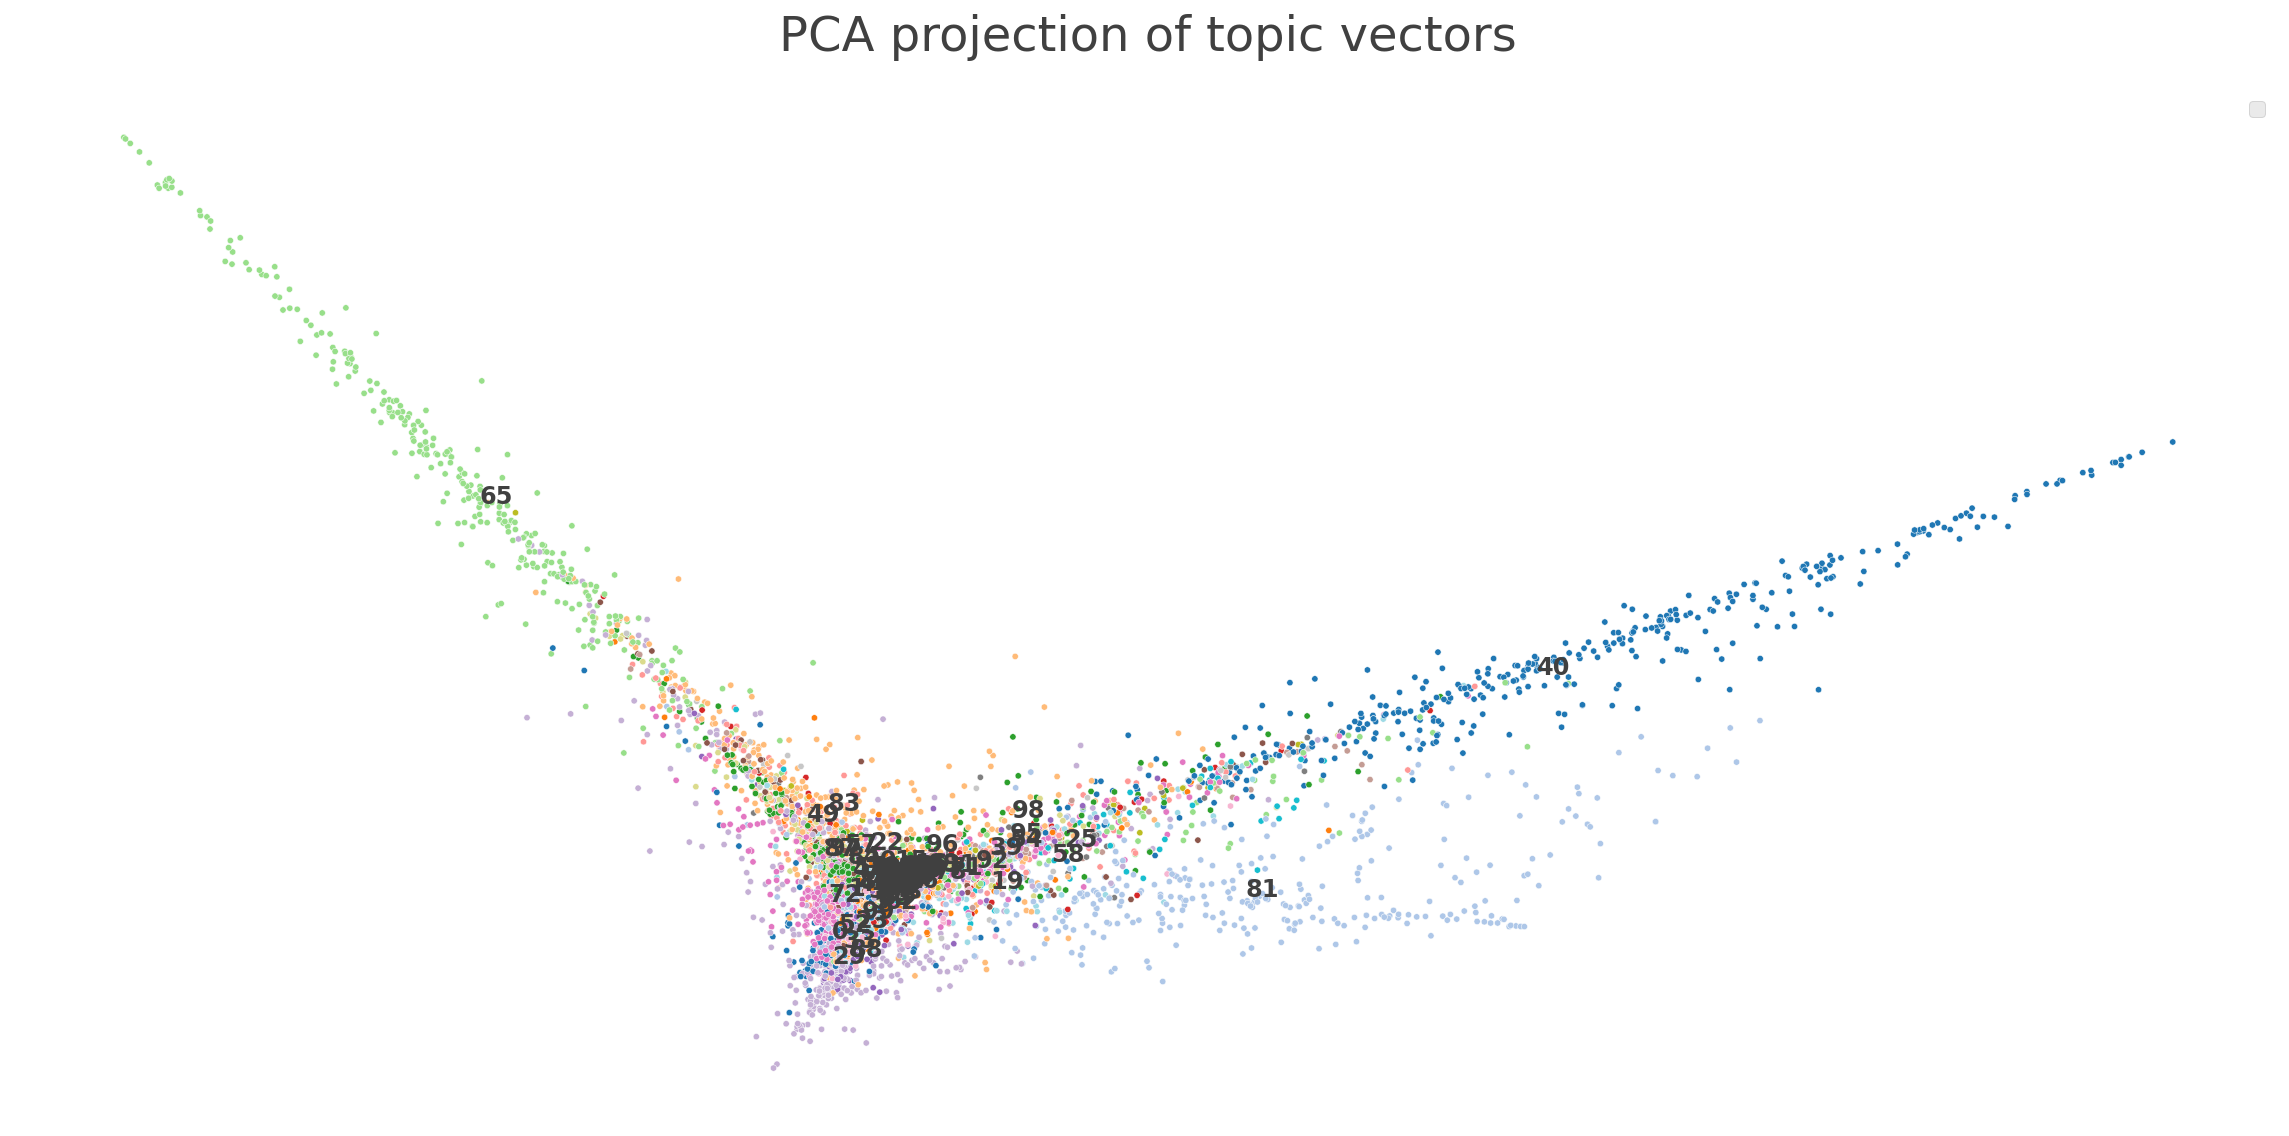

In [70]:
df_embed_pca = pd.DataFrame(embed_pca[:, :2], columns=["x", "y"])
df_embed_pca["labels"] = topic_labels
topic_centers = df_embed_pca.groupby("labels")[["x", "y"]].median()

create_graph(df_embed_pca, topic_centers, "PCA projection of topic vectors")

### UMAP
- With [UMAP](https://umap-learn.readthedocs.io/en/latest/) we get a 2D projection that tries to represent much more of the structure in the vector space.
- The various topics appear much more clustered.
- However, the visualization is not optimal yet since we do not have any indication, what the topic ids stand for. Therefore I will find the 2D coordinates of primary genres and plot these in conjunction with the topic clusters.

In [75]:
umapper = umap.UMAP(n_components=2, n_neighbors=15, random_state=42)
embed_umap = umapper.fit_transform(topic_vectors)

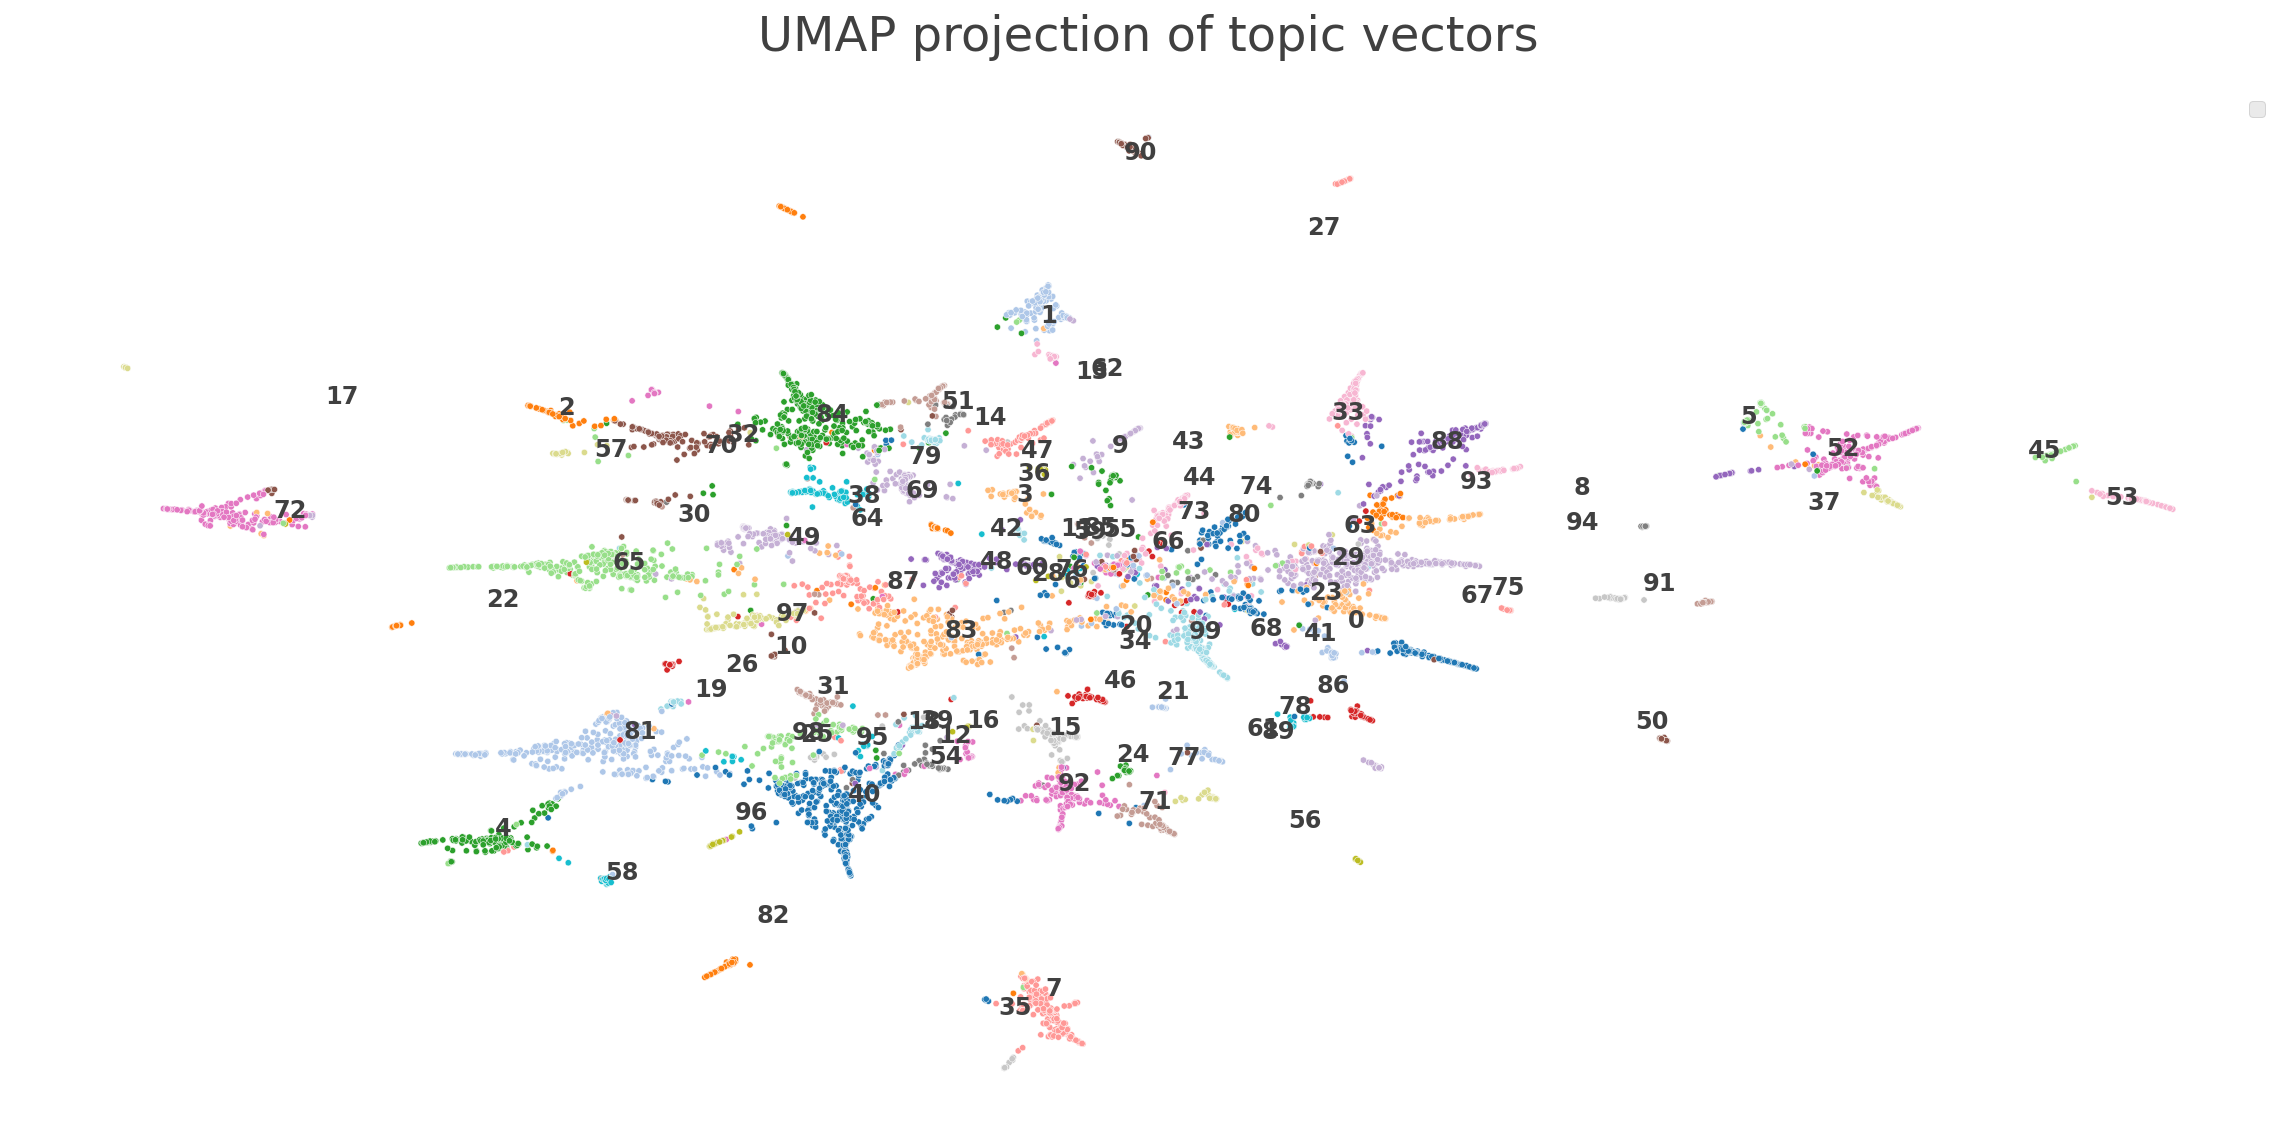

In [76]:
df_embed_umap = pd.DataFrame(embed_umap, columns=["x", "y"])
df_embed_umap["labels"] = topic_labels
topic_centers = df_embed_umap.groupby("labels")[["x", "y"]].mean()

create_graph(df_embed_umap, topic_centers, "UMAP projection of topic vectors")

In [83]:
top_n = 80

# Get top n primary genres.
top_genres = df.primary_genre.value_counts()[:top_n].index

# Map top n genres to new features. Set all other genres to one generic label «zzz_others».
df["top_genre_labels"] = df.primary_genre.apply(lambda x: x if x in top_genres else "zzz_others")

# Label encode top n genre labels.
lbl_enc = LabelEncoder()
genre_labels = lbl_enc.fit_transform(df.top_genre_labels)

# Create boolean mask if genre is top n genre or not.
mask = np.where(genre_labels==top_n, True, False)

# Podcasts with minimal textual content confound results. 
# I calculate the word counts for each document to filter out these erroneous samples.
df["word_count"] = [len(x) for x in all_tokens]
min_word_count = 150
to_drop = df[df.word_count<min_word_count].index

# Calculate embedding centers for top n genres.
# Use median to remove influence of outliers.
df_embed_umap["primary_genre_labels"] = df.top_genre_labels
topic_centers = df_embed_umap.drop(to_drop).groupby("primary_genre_labels")[["x", "y"]].median()

In [88]:
def create_graph_with_topic_centers():
    fig, ax = plt.subplots(figsize=(16, 16))
    sns.scatterplot(data=df_embed_umap.loc[mask], x="x", y="y", color="lightgrey", ax=ax, s=20)
    sns.scatterplot(data=df_embed_umap.loc[np.invert(mask)], x="x", y="y", color="lightgrey", ax=ax, s=20)

    # adjust_up = ["TV und Film", 'Religion und Spiritualität', 'Mentale Gesundheit', 'Kindererziehung', 
    #              'Wissenschaft', 'Haus- und Wildtiere', 'Sozialwissenschaften', 'Reisen und Orte', 
    #              'Bildende Kunst', 'Darstellende Kunst', 'Sprachen lernen', 
    #              "Comedy", ]

    # adjust_down = ["Stand-Up-Comedy", 'Selbstverwirklichung', 'Gesundheit und Fitness', 
    #                'Kinder und Familie', "Musik", 'Neues aus der Technik', 'Wirtschaft', 
    #                'Musikinterviews', "Musikgeschichte", "Neues aus der Unterhaltung", 
    #                ]

    for idx, row in topic_centers.iterrows():
        x_, y_ = row.x, row.y
        genre_name = str(idx)

        # # Adjust y position to avoid overlap of genre labels.
        # if str(idx) in adjust_up:
        #     y_ +=.25
        # if str(idx) in adjust_down:
        #     y_ -=.25

        if genre_name=="Gesundheit und Fitness":
            genre_name="Gesundheit\nundFitness"
        if genre_name=="Geschichten für Kinder":
            genre_name="Geschichten\nfür Kinder"   
        # if genre_name=="Comedy Interviews":
        #     genre_name="Comedy\nInterviews"  
        if genre_name=="zzz_others":
            continue

        ax.text(x_, y_, genre_name, 
                fontsize=10, 
                weight='bold', 
                color="darkred",
                horizontalalignment='center', 
                verticalalignment='center'
               )


    ax.set_facecolor("white")
    plt.title(f"Mapping top {top_n} primary genres to topic embeddings", size=TITLE_SIZE, pad=TITLE_PAD)
    # plt.xlim(-6, 8)
    plt.ylim(-3.5, 15)
    plt.legend([])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig("_visualizations/mapping.png")
    plt.show()

- The graph clearly shows that the 2D projection of the modelled topic vector space is sensible. 
- Related topics appear closer together, e.g. `Geldanlage`, `Wirtschaft`, `Management`, `Technologie` and `Neues aus der Technik`. Unrelated topics have a large distance, e.g. `Essen` or `Wahre Kriminalfälle` and `Religion`. 

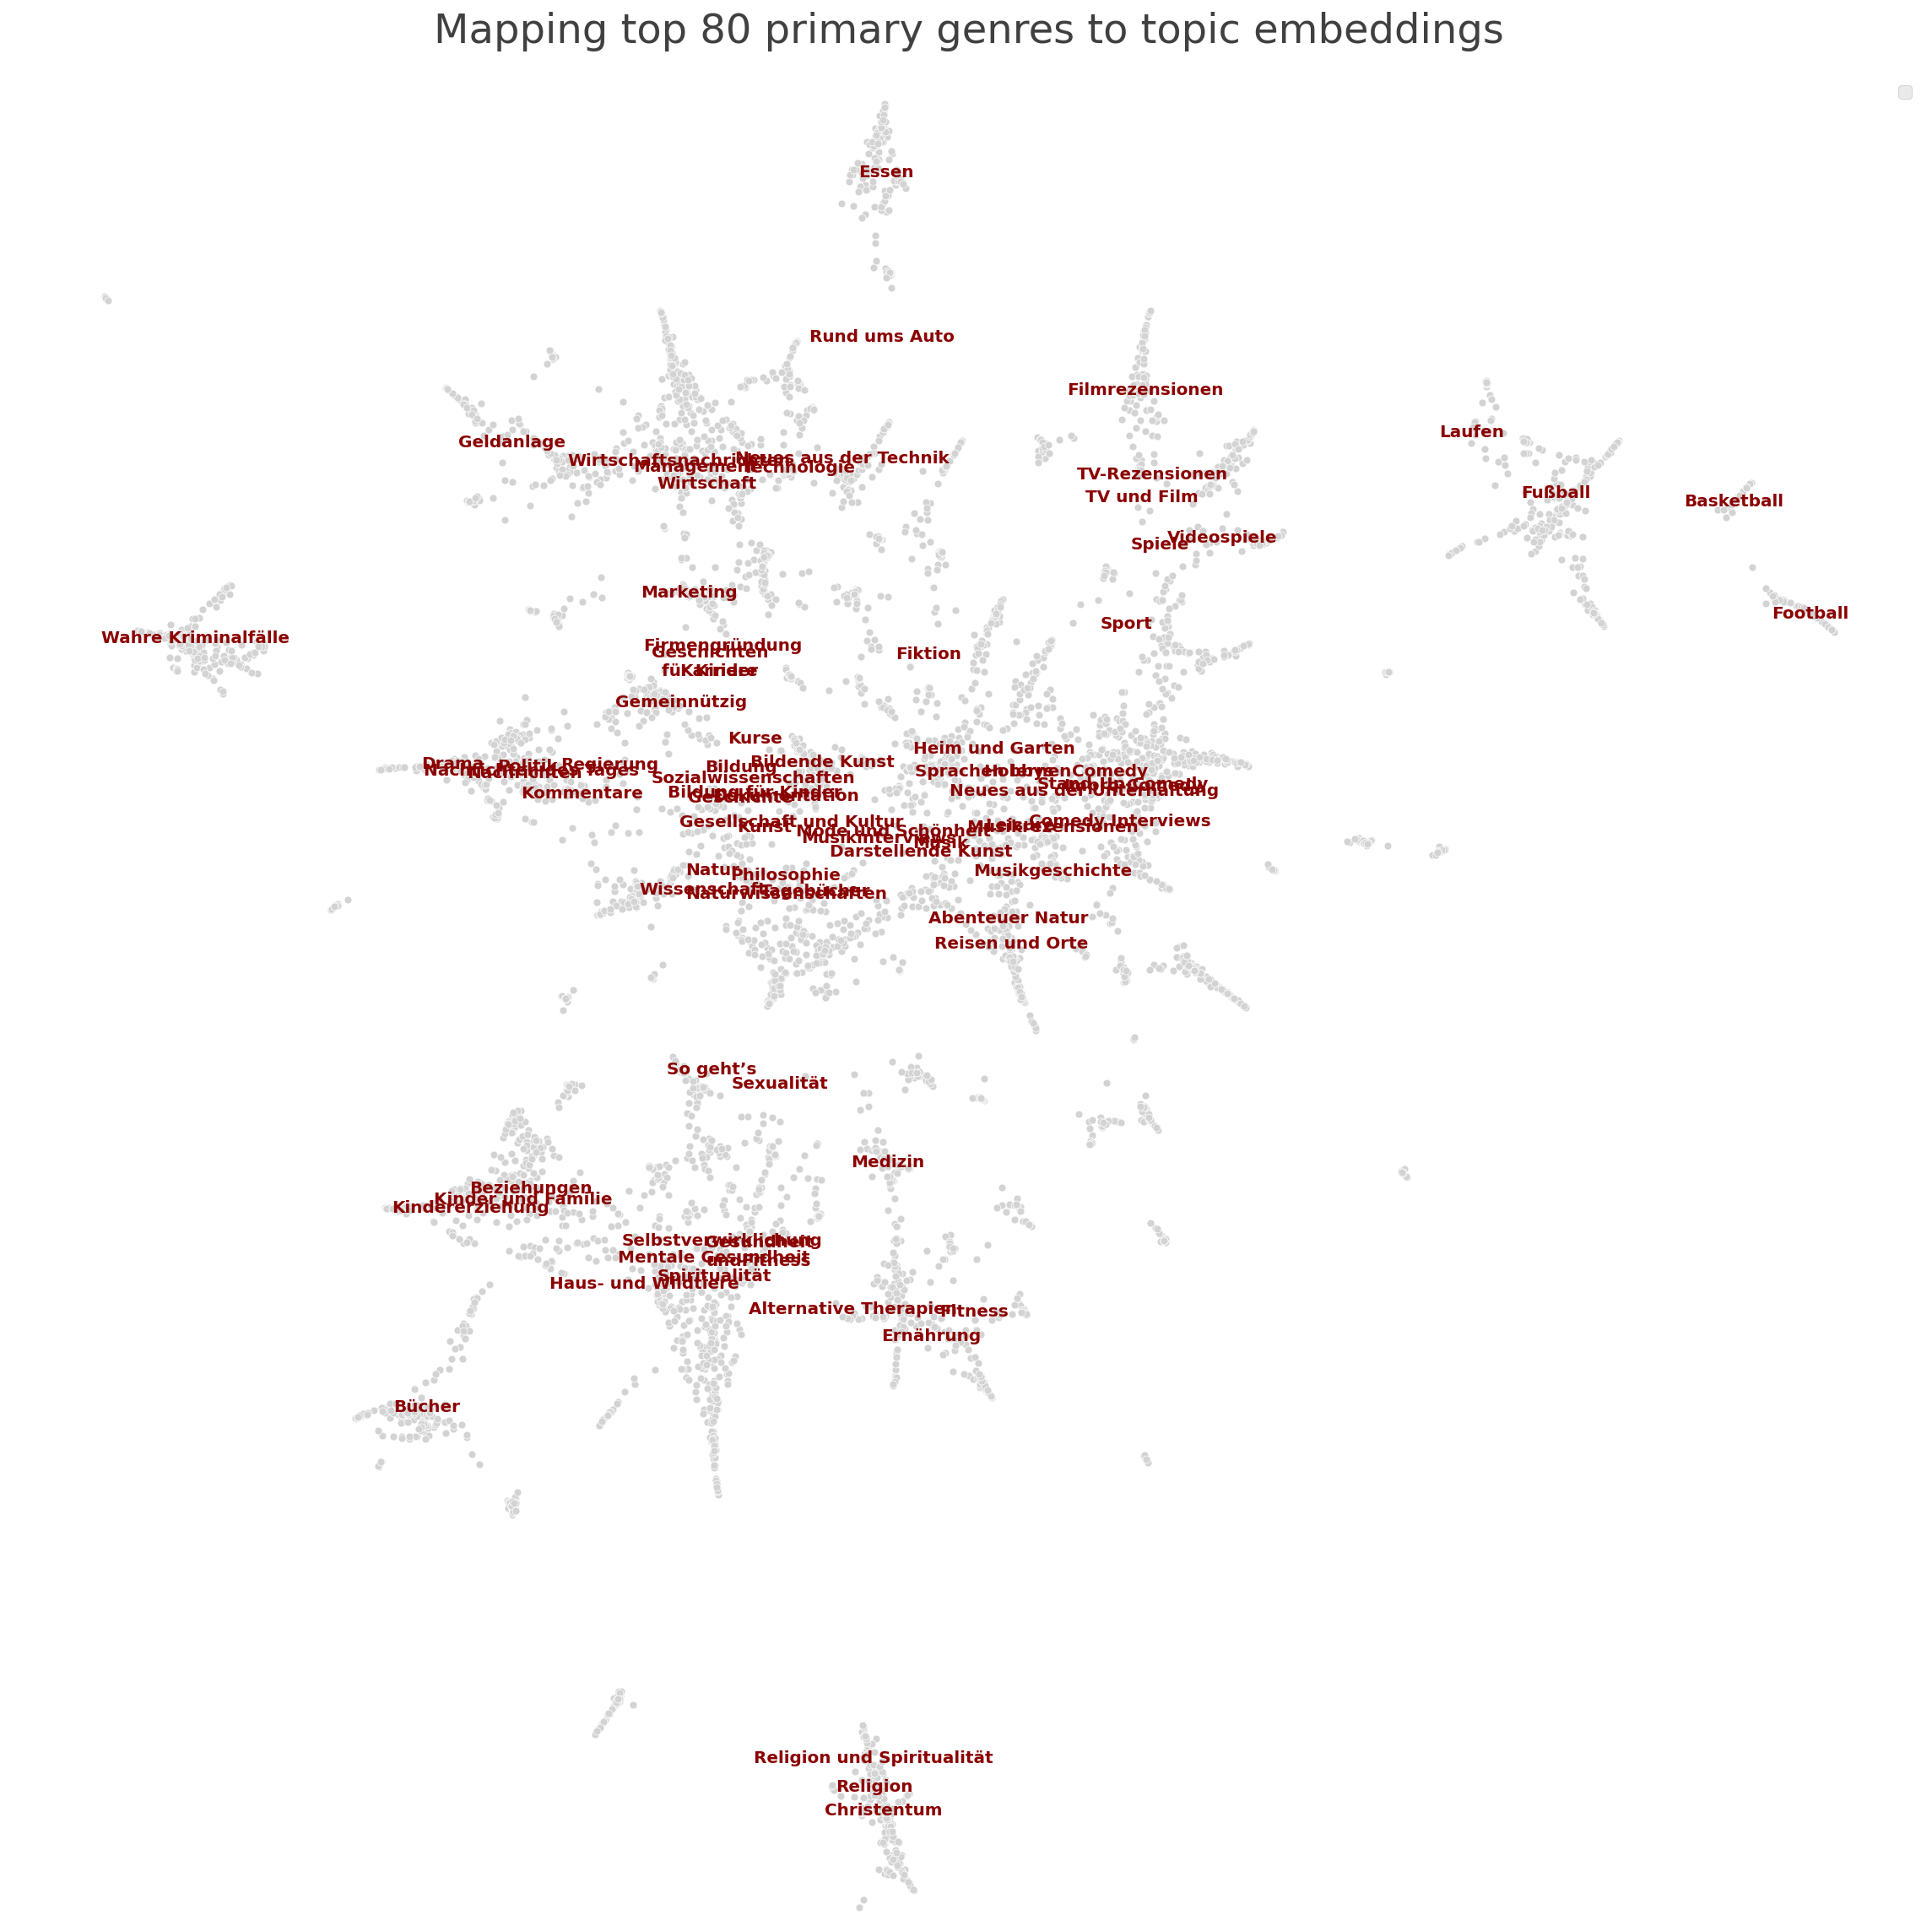

In [89]:
create_graph_with_topic_centers()

## Visualize LDA model with pyLDAvis

In [66]:
vis = pgensim.prepare(model, all_corpus, all_dict)
# Using pyLDAvis inline in jupyterlab breaks the UI. 
# The workaround is to export the visualization as a HTML file.
pyLDAvis.save_html(vis, "_visualizations/pyLDAvis.html")

## Calculate topic distances and query similar documents
Let´s calculate the cosine distance of each document to each of all other documents. This will allow us to retrieve similar and dissimilar podcast for any given podcast.

In [47]:
# Calculate distance from every document topic vector to each of all other document vectors.
doc_distances = scipy.spatial.distance.cdist(topic_vectors, topic_vectors, metric="cosine")
print(f"Calculated document distance matrix of shape {doc_distances.shape}.")

Calculated document distance matrix of shape (6636, 6636).


In [48]:
cols_to_show = ['artistName', 'title', 'subtitle', 'summary', 'primary_genre', 'topic_label']

def query_similar_podcasts(podcast_title, n_results=10, furthest=False):
    query_idx = df[df.title.str.contains(podcast_title, case=False)].head(1).index.item()
    
    if furthest==False:
        sorted_distances = doc_distances[query_idx].argsort()
        print(f"Closest podcasts to «{podcast_title}».\nFirst entry in list is queried podcast itself.\n")
    else:
        sorted_distances = doc_distances[query_idx].argsort()[::-1]
        print(f"Furthest podcasts to «{podcast_title}».")
    
    # Improve search results by filtering out podcasts that have less describing words than min_word_count.
    display(df.iloc[sorted_distances][df.word_count>=min_word_count][cols_to_show].head(n_results))

Querying various terms and retrieving the most similar/dissimilar podcast reveals again, that the LDA model is effective and represents the data well.

In [49]:
query_similar_podcasts("Tagesschau")
query_similar_podcasts("Tagesschau", furthest=True)

Closest podcasts to «Tagesschau».
First entry in list is queried podcast itself.



,artistName,title,subtitle,summary,primary_genre,topic_label
3,ARD-aktuell,Tagesschau (Audio-Podcast),Deutschlands erfolgreichste Nachrichtensendung...,None,Nachrichten,65
544,ARD-aktuell,Tagesschau (1280x720),Deutschlands erfolgreichste Nachrichtensendung...,None,Nachrichten,65
92,ARD-aktuell,Tagesthemen (Audio-Podcast),Die Tagesthemen als Audio-Podcast.,None,Nachrichten,65
1636,Süddeutsche Zeitung,Auf den Punkt,None,Die Nachrichten des Tages - von der Süddeutsch...,Nachrichten,65
1955,NDR Info,Die Nachrichtenlage am Morgen,Das Wichtigste aus Norddeutschland und der Wel...,None,Nachrichten des Tages,65
2514,ZDFde,maybrit illner (AUDIO),None,Der Polit-Talk im ZDF mit Moderatorin Maybrit ...,TV und Film,65
686,Bayerischer Rundfunk,BR24 Thema des Tages,"Fundiert, informativ, tiefgründig: Im Thema de...","Fundiert, informativ, tiefgründig: Im Thema de...",Nachrichten des Tages,65
1185,ZEIT ONLINE,Was jetzt?,Der Nachrichtenpodcast,Der Nachrichtenpodcast von ZEIT ONLINE. Montag...,Nachrichten,65
120,hr,Der Tag in Hessen,None,None,Nachrichten des Tages,65
367,Deutscher Bundestag,Bundestags-ABC - Audio Podcasts,Deutscher Bundestag,Deutscher Bundestag,Nachrichten,65


Furthest podcasts to «Tagesschau».


,artistName,title,subtitle,summary,primary_genre,topic_label
3317,MARKET TEAM Alumni,MT GS Alumni Podcast,"Triologe über das, was passiert ist, passieren...","Triologe über das, was passiert ist, passieren...",Gemeinnützig,86
2674,Matthias Klein,Erziehen mit Erfolg - Daumen-Hoch-Pädagogik,Daumen-Hoch-Pädagogik - Erziehen mit Erfolg,Daumen hoch für diesen Podcast - Daumen hoch f...,Kindererziehung,81
2676,Börsen Radio Network AG,Börsenradio to go Marktbericht,None,Alles rund um die Börse. Die Börse zum hören: ...,Wirtschaftsnachrichten,57
2677,SOULTEKK,SOULTEKK LIVE MIXTAPES,Audio Podcast from SOULTEKK w/ Love,SOULTEKK LIVE MIXTAPES is a cool new Music Pod...,Musikgeschichte,75
2680,neon.de / Audio Alliance,"NEON Unnützes Wissen - der Podcast, den man ni...",<p>Wissen ist Macht – und deshalb wollen wir e...,<p>Wissen ist Macht – und deshalb wollen wir e...,Comedy,90
2681,Katharina Appia,"Alles da, nur Ella nicht. (Über)Leben ohne Kind",None,"In meinem Podcast „Alles da, nur Ella nicht. (...",Gesellschaft und Kultur,81
2685,Janina Pernsot,"Liebe, was du tust",Be happy and be light in professional and pers...,"Mit meinem Podcast gebe ich dir Impulse, wie d...",Selbstverwirklichung,40
2691,Dr. Carsten Lekutat und Nora Oschatz,"Gute Fette, Schlechte Fette",None,Denn es gibt gute Fette und es gibt schlechte ...,Fitness,77
2692,10 Minuten zu Fuß,10 Minuten zu Fuß,Der Erfolgs Podcast für Hörer mit Niveau! Komm...,Der Erfolgs Podcast für Hörer mit Niveau! Komm...,Comedy Interviews,29
2693,Anne und Sandra,Tittentrash,None,Wir schreiben das Jahr 2019. Podcasts waren 20...,Impro-Comedy,23


In [50]:
query_similar_podcasts("Zum Scheitern Verurteilt")
query_similar_podcasts("Zum Scheitern Verurteilt", furthest=True)

Closest podcasts to «Zum Scheitern Verurteilt».
First entry in list is queried podcast itself.



,artistName,title,subtitle,summary,primary_genre,topic_label
6456,Laura Larsson & Simon Dömer,Zum Scheitern Verurteilt,None,In der Fantasie ist alles möglich. Aber warum ...,Comedy,27
2528,Nizar & Shayan,Die Deutschen,Zuerst kam der Zusammenbruch der Zivilisation:...,Zuerst kam der Zusammenbruch der Zivilisation:...,Stand-Up-Comedy,27
1761,"Flo, Paul & Olli",Die Sprechstunde 🎙️,Dein Lieblings-Podcast!,"Die Sprechstunde mit LeFloid, Olli &amp; Paul ...",Comedy,27
2243,Markus Dreesen | Podcast Monkey,#100malMusiklegenden,"Musik ist unser Leben. Wenn ein Song läuft, da...","Musik ist unser Leben. Wenn ein Song läuft, da...",Musikgeschichte,27
6302,Lane Acheampong & Mete Konya,Ganz schön Okay,Das eben ist ganz schön okay... Lane und Mete ...,<p>Lane und Mete sind 2 Freunde die sich beim ...,Comedy,27
2651,laserluca,Dick & Doof,None,"Sexy, charmant und unfassbar intelligent - all...",Comedy,27
549,"Stefan Titze, Florentin Will",DAS PODCAST UFO,DAS PODCAST UFO,Zwei Grenzgänger widmen sich den Themen unsere...,Comedy,27
1912,Papaplatte & Reeze,Edeltalk - mit Dominik & Kevin,Ein Podcast mit Dominik &amp; Kevin. papaplatt...,Ein Podcast mit Dominik & Kevin. papaplatte@ne...,Comedy,27
1631,Ricarda,Busenfreundin,Es ist nicht alles gay was glänzt!,In „Busenfreundin“ redet Comedy-Autorin Ricard...,Comedy,27
900,Andreas Lingsch & Lars Eric Paulsen,RATTENKÖNIGE,Podcast & Life-Coaching,<p>Die RATTENKÖNIGE Andreas Lingsch und Lars E...,Comedy,27


Furthest podcasts to «Zum Scheitern Verurteilt».


,artistName,title,subtitle,summary,primary_genre,topic_label
6635,Thomas Sachsenmaier & Simon Ihlenfeldt,Der GmündCast,Preiset hoch die Stadt Gamundia!!! Der erste S...,Preiset hoch die Stadt Gamundia!!! Der erste S...,Gesellschaft und Kultur,82
2279,"Pia Maselowsky, Florian Heinz",Château Picard – ein Star Trek Podcast,Ein Star Trek Podcast,Pia und Flo sprechen über den größten Star Tre...,TV-Rezensionen,46
2281,Christin Schneider,Wilke hautnah - Aus dem Leben eines Oberbürger...,Aus dem Leben eines Oberbürgermeisters,"""Wilke hautnah - Aus dem Leben eines Oberbürge...",Regierung,23
2282,Team Chris Cross,CrossCast - Der OCR Podcast,"Der sportliche Podcast rund um OCR, Laufen, Mo...",CrossCast - Der OCR Podcast. In unserem CrossC...,Laufen,61
2283,Dj Mr. MAGIC,Dj Mr. MAGIC,Dj MIX MIXTAP,Dj Mr. Magic\nProfessionelle DJ\n\nWebsite: mr...,Musik,17
2284,"Laura Fröhlich, Mamablog Heute ist Musik",Lauras Müttersprechstunde: Mama-Support mit Sound,Herzlich willkommen in der Müttersprechstunde ...,"Ich bin Laura, Mutter von drei Kindern und ich...",Kinder und Familie,81
2285,Audible Original,Frau Bauerfeind hat Fragen - Staffel 1,Audible Original Podcast,Das Prinzip dieser Podcastshow ist eigentlich ...,Comedy,83
2286,Audible Original,180Grad mit Lukas Klaschinski - Staffel 1,Audible Original Podcast,"Lukas Klaschinski trifft Menschen, deren Leben...",Tagebücher,83
2288,MutimBauch & der Schnüffi,Teilzeit-Spießer,None,"Wir sind weltoffen, tätowiert, medienaffin, ve...",Kindererziehung,81
2289,Kai Stührenberg und Patrick Petersen,Freimaurer im Gespräch - Der Podcast,Der gemeinsame Podcast mit Kai Stührenberg und...,Der gemeinsame Podcast mit Kai Stührenberg und...,Spiritualität,81


In [51]:
query_similar_podcasts("Alles gesagt")
query_similar_podcasts("Alles gesagt", furthest=True)

Closest podcasts to «Alles gesagt».
First entry in list is queried podcast itself.



,artistName,title,subtitle,summary,primary_genre,topic_label
1497,ZEIT ONLINE,Alles gesagt?,Der unendliche Interviewpodcast,Wir befragen außergewöhnliche Menschen - so la...,Gesellschaft und Kultur,23
953,Nora Hespers und Rita Molzberger,Was denkst du denn?,Der Mit- und Nachdenkpodcast,Wo ist die Schamgrenze - zum Beispiel in der S...,Philosophie,23
4485,Radio Bremen,3nach9 – Der Talk mit Judith Rakers und Giovan...,None,None,Gesellschaft und Kultur,83
4550,"Isabella Fischer, Thomas Correll, Lea-Verena M...",Mit.Menschen - der Podcast von nordbayern.de v...,None,Wir wollen mit unseren Mitmenschen reden - auc...,Gesellschaft und Kultur,83
3673,WESER-KURIER,Wer macht so was? Streifzüge durchs junge Bremen,None,Wir sind junge Journalisten des WESER-KURIER u...,Gesellschaft und Kultur,83
949,Pool Artists,Hört Hört - Der Weihnachtskalender,Der Podcasts-Podcast,Das Team Hört Hört und die Pool Artists stelle...,Gesellschaft und Kultur,23
5494,Studiengang Fashion Journalism & Communication...,STADT.LAND.MODE.,Diskutieren mit Stil. Der Fashion-Podcast mit ...,"Hey, hörst du das? Das ist STADT.LAND.MODE. Di...",Design,23
3457,ZDFneo,Laura Karasek – Zart am Limit,None,Der Podcast zur Sendung mit Laura Karasek - An...,Beziehungen,83
3808,Caro & Maria,narrisch & wuid - Der Podcast,"Wir san Maria und Caro, zwoa Studentinnen aus ...","Wir san Maria und Caro, zwoa Studentinnen aus ...",Neues aus der Unterhaltung,23
1576,Der Postillon,Podcastillon,Der News-Podcast des Postillon,Podcastillon – der News-Podcast des Postillon ...,Comedy,23


Furthest podcasts to «Alles gesagt».


,artistName,title,subtitle,summary,primary_genre,topic_label
3473,Kathi Lehmann,Werde zum Lerncoach für dein Kind,Podcast der kreativen Lernwerkstatt,Dies ist der Podcast der kreativen Lernwerksta...,Bildung für Kinder,81
1555,Eva-Maria & Wolfram Zurhorst,Liebe kann alles - Der Beziehungspodcast mit E...,None,In unserem „Liebe kann alles“ Podcast geben wi...,Mentale Gesundheit,81
3007,Susanne Dröber,Happy little souls - Bewusst sein mit Kindern,None,"Der Podcast für Mütter, die das Leben mit ihre...",Kindererziehung,81
907,Rocket Beans TV,Nachspiel,None,Manche Spiele lassen uns einfach nicht mehr lo...,Videospiele,88
1549,Rosa Blume,Schwanger - was jetzt?,"Willkommen beim Podcast ""Schwanger - was jetzt...","Willkommen beim Podcast ""Schwanger - was jetzt...",Sexualität,86
1552,Geocaching in 100 Sekunden,Geocaching in 100 Sekunden,Willkommen beim “Geocaching in 100 Sekunden” P...,Willkommen beim “Geocaching in 100 Sekunden” P...,Leisure,86
906,Pastor Gunnar Engel,aus glauben leben - Pastor Gunnar Engel,Hier gibt es alle Predigten und Vorträge von G...,None,Religion und Spiritualität,7
904,Marco,Ein Minimalist erzählt,Ein Minimalismus Podcast: Ein Minimalist erzäh...,Hier spreche ich über mein Leben als Minimalis...,Beziehungen,73
903,"by Steffen Kirchner - Mentaltrainer, Lifecoach...",UPGRADE YOUR LIFE Podcast von Steffen Kirchner,None,Der UPGRADE YOUR LIFE Podcast von Steffen Kirc...,Selbstverwirklichung,54
901,Adrian Lukas,Wechselzone Podcast,"Ob Laufen, Radfahren, Schwimmen, Trail oder Hi...","Ob Laufen, Radfahren, Schwimmen, Trail oder Hi...",Sport,61


In [52]:
query_similar_podcasts("Beste Freundinnen")
query_similar_podcasts("Beste Freundinnen", furthest=True)

Closest podcasts to «Beste Freundinnen».
First entry in list is queried podcast itself.



,artistName,title,subtitle,summary,primary_genre,topic_label
571,Auf die Ohren,Beste Freundinnen,Beste Freundinnen,Das ist der ultra ehrliche Männerpodcast. Zwei...,Comedy,81
3613,SoDenktEinMann,Scheiß auf Ihn und date andere Männer!,"Hast du dich schon immer gefragt, wie ein Mann...","Hast du dich schon immer gefragt, wie ein Mann...",Selbstverwirklichung,81
2148,Jana Pollrich & Alessa Sofia Arndt,Auf nen Vino...by Jana & Alessa,"‚Auf nen Vino‘ ist ein Podcast, bei dem @janas...","‚Auf nen Vino‘ ist ein Podcast, bei dem @janas...",Beziehungen,81
1391,Auf die Ohren,Beste Vaterfreuden,None,"Fernab von Klischees, besprechen Max und Jakob...",Kinder und Familie,81
3037,Hanna Marie,Hanna Marie,"hey \nich bin Hanna, 20 Jahre alt und seit mit...","hey \nich bin Hanna, 20 Jahre alt und seit mit...",Mentale Gesundheit,81
6048,Senna Gammour & Seyda Taygur,Zuckerwatte,Zuckerwatte ist ein Podcast von Senna Gammour ...,Zuckerwatte ist ein Podcast von Senna Gammour ...,Beziehungen,81
3440,Michael Nast,Generation Beziehungsunfähig,None,Schonungslos ehrlich sprechen Marie und Bestse...,Gesellschaft und Kultur,81
4836,frobi-podcast.de,"Frobi, der Vater Tochter Podcast",Der Vater Tochter Podcast rund um unser Alltag...,Der Vater Tochter Podcast rund um unser Alltag...,Kindererziehung,81
4334,Dani,LOVE MEET UP,None,"LOVE MEET UP bringt dir neue Perspektiven, sp...",Beziehungen,81
3309,Yvonne Mouhlen,Plan B - Yvonne Mouhlen,Auch du hast bestimmt einen ganz anderen Plan ...,Auch du hast bestimmt einen ganz anderen Plan ...,Mentale Gesundheit,81


Furthest podcasts to «Beste Freundinnen».


,artistName,title,subtitle,summary,primary_genre,topic_label
0,Michael Greth,SharePointPodcast - Der Modern Workplace Podcast,Themen.Trends.Tipps.Tricks.Talk. mit Michael G...,Das Urgestein unter den Podcasts - seit 7.2.20...,Technologie,84
1972,eigentümlich frei,Herrengedeck,None,"Die Sendung Herrengedeck, der zumeist kultivie...",Nachrichten,59
1951,Veronika Wölfel,JUNILOVE SHOW 'Enjoy The Now' SHOW,Aus Diäten und Krankheiten zurück zu Gesundhei...,Willkommen zum Junilove Podcast „Enjoy the Now...,Ernährung,40
4725,WW Deutschland GmbH,WW Helden - Mehr als nur Abnehmen,None,WW Helden - dein Podcast für mehr als nur Abne...,Ernährung,71
1953,Thomas Friebe,Auftreten · Präsentieren · Überzeugen,Du willst mehr über effektive Kommunikation wi...,Du willst mehr über effektive Kommunikation wi...,Karriere,21
4723,"Daniel Messling, Patrick Rosen",Geladen - der Batteriepodcast,None,Patrick Rosen und Daniel Messling sprechen mit...,Chemistry,1
1955,NDR Info,Die Nachrichtenlage am Morgen,Das Wichtigste aus Norddeutschland und der Wel...,None,Nachrichten des Tages,65
4721,Prof. Dr. Christoph Juhn,GmbH Steuerrecht mit Prof. Christoph Juhn,Steuerberater Prof. Christoph Juhn berichtet i...,Steuerberater Prof. Christoph Juhn berichtet i...,Firmengründung,49
4720,Melanie Rieken & Mo Röttgen,Kraut im Ohr - Dein Wildkräuter Podcast,Dein Wildkräuter Podcast,Kraut im Ohr ist dein Podcast rund um Wildkräu...,Heim und Garten,63
1959,Shaykh Mahmud Kellner,O Kind! - Der Brief an einen Schüler (Imam al-...,„Madrasah – Verein für islamische Bildung und ...,„Madrasah – Verein für islamische Bildung und ...,Islam,48


In [53]:
query_similar_podcasts("Finanzfluss")
query_similar_podcasts("Finanzfluss", furthest=True)

Closest podcasts to «Finanzfluss».
First entry in list is queried podcast itself.



,artistName,title,subtitle,summary,primary_genre,topic_label
3167,Finanzfluss,Finanzfluss Podcast,None,"Auch du kannst lernen, mit Geld umzugehen! Wir...",Geldanlage,70
513,Stefan Obersteller,Geldbildung.de - Finanzielle Bildung über Börs...,Finanzielle Bildung - Geldbildung.de,"Der Finanzpodcast, der Dir hilft Anlagefehler ...",Geldanlage,70
428,Holger Grethe,Zendepot Podcast: Erfolgreich Vermögen aufbaue...,"Lebe aktiv, Investiere passiv.",Der Zendepot Podcast liefert dir Ideen und Str...,Geldanlage,70
643,Albert Warnecke und Daniel Korth,Der Finanzwesir rockt - Der etwas andere Podca...,"Für Leute, die ihr Geld selbst anlegen","Hallo, wir sind Daniel, ein Ex-Berliner, und A...",Geldanlage,70
1295,Christoph Geiler,Finanzküche,Immer das richtige Rezept!,"Unsere Vision ist es, den Wandel hin zu einer ...",Geldanlage,70
4380,Lena Kronenbürger & Ingo Schröder,How I met my money,Der Finanzpodcast für Anfänger,Der Finanzpodcast für Anfänger von Lena Kronen...,Geldanlage,70
2300,Sven Stopka,Finanzpodcast | Vermögensaufbau abseits der Masse,"Klartext in Sachen Vermögensaufbau, Investment...",Finanzen sind für viele ein umfangreiches aber...,Geldanlage,70
3484,Anja & Anika von Finanztip,Auf Geldreise - der Finanztip-Podcast für Frauen,None,Über Geld spricht man nicht. Wir schon – in un...,Geldanlage,70
2349,Ernst Rudolf,Die Durchsage - Ein Service für die Kunden der...,Einmal im Monat setzt Ernst Rudolf über aktuel...,Einmal im Monat setzt Ernst Rudolf über aktuel...,Sport,70
1606,Geldheld Marco Lachmann-Anke,Geldhelden Podcast,Finanzielle Intelligenz einfach und umsetzbar ...,Der Geldhelden Podcast liefert dir geballte fi...,Geldanlage,70


Furthest podcasts to «Finanzfluss».


,artistName,title,subtitle,summary,primary_genre,topic_label
6635,Thomas Sachsenmaier & Simon Ihlenfeldt,Der GmündCast,Preiset hoch die Stadt Gamundia!!! Der erste S...,Preiset hoch die Stadt Gamundia!!! Der erste S...,Gesellschaft und Kultur,82
2828,Wolf Braun,SEO für Unternehmen - Suchmaschinenoptimierung...,"Wer im Internet unterwegs ist weiß, dass man s...","Wer im Internet unterwegs ist weiß, dass man s...",Marketing,38
2808,GEO / Audio Alliance,Herr Faktencheck,"Auf dem Schreibtisch eines Dokumentars, besser...","Auf dem Schreibtisch eines Dokumentars, besser...",Naturwissenschaften,90
2809,Maxim Mankevich,Die Köpfe der Genies mit Maxim Mankevich,None,"Sie sind Wunderkinder, Visionäre, Magier, Geni...",Selbstverwirklichung,7
2810,Our Daily Bread Ministries,Unser Täglich Brot | Our Daily Bread Ministrie...,Our Daily Bread Ministries - Herausgeber von U...,The audio version of Our Daily Bread is an eff...,Christentum,7
2811,Immer wieder VfL,Immer wieder VfL,"Der VfL Bochum Podcast.\n\nVon Fans, für Fans.","Der VfL Bochum Podcast.\n\nVon Fans, für Fans.",Fußball,37
2812,Kamphausen Media GmbH,Jetzt oder nie! Tolle | Typen | Talks,Der Wunsch nach einem Leben im Jetzt dürfte de...,Der Wunsch nach einem Leben im Jetzt dürfte de...,Spiritualität,40
2813,Veronika Vehr,Freude am Erfolg: Businesstipps für Hörakustik...,Businesstipps für Hörakustiker,Als Themen hält Veronika Vehr in erster Linie ...,Karriere,84
580,"Birgit Schürmann: Schauspielerin, Trainerin & ...","Rhetorik, die im Kopf bleibt!","Birgit Schürmann: Schauspielerin, Trainerin & ...",Der Rhetorik-Podcast von Birgit Schürmann ist ...,Marketing,21
2815,Amnesty International Deutschland e.V.,Amnesty International HU Berlin & Charité,Dies ist der Podcast der Amnesty International...,Dies ist der Podcast der Amnesty International...,Gesellschaft und Kultur,83


## Calculate genre distances
We can now do the same distance calculations for primary genres. We average all topic vectors of podcasts of a particular primary genre and retrieve the cosine similarities.

In [54]:
tmp = []
for name, data in df.groupby("primary_genre"):
    tmp.append((name, data.index.to_list()))
df_genres = pd.DataFrame(tmp, columns=["primary_genre", "podcast_idx"])

tmp = []
for indices in df_genres.podcast_idx.values:
    tmp.append(np.mean(topic_vectors.iloc[indices].values, axis=0))
df_genres["embedding"] = tmp

embeddings = pd.DataFrame(df_genres.embedding.tolist())

In [55]:
genre_distances = scipy.spatial.distance.cdist(embeddings, embeddings, metric="cosine")
print(f"Calculated genre distance matrix of shape {genre_distances.shape}.")

Calculated genre distance matrix of shape (110, 110).


In [56]:
def query_genre(genre_name, n_results=10):
    query_idx = df_genres[df_genres.primary_genre.str.contains(genre_name, case=False)].head(1).index.item()
    closest_distances = genre_distances[query_idx].argsort()
    furthest_distances = closest_distances[::-1]
    print(f"Closest genres to «{genre_name}».")
    print(df_genres.iloc[closest_distances].primary_genre.head(n_results).values)
    print()
    print(f"Furthest genres to «{genre_name}».")
    print(df_genres.iloc[furthest_distances].primary_genre.head(n_results).values)

Querying closest/furthest primary genres to any give genre again indicates that LDA modelled the data in a sensible way.

In [57]:
query_genre("Sport")

Closest genres to «Sport».
['Fantasy Sport' 'Football' 'Eishockey' 'Sport' 'Rugby' 'Sportnews'
 'Basketball' 'Fußball' 'Tennis' 'Volleyball']

Furthest genres to «Sport».
['Hinduismus' 'Buddhismus' 'Physik' 'Alternative Therapien'
 'Kindererziehung' 'Mathematics' 'Filmrezensionen' 'Filmgeschichte'
 'Ernährung' 'Christentum']


# Conclusions

- LDA and its underlying bag-of-word model prove astonishingly effective. 
- The results are quite meaningful and promising. 
- The topic mixture for each document can be used as a vector and by that we can search for similar and dissimilar podcast and genres.
- The algorithm trains fast and can be updated.